## Imports

In [1]:
import gym
import time
import base64
import imageio
import numpy as np

import tensorflow as tf
import tensorflow_probability as tfp
tfkl = tf.keras.layers

import matplotlib.pyplot as plt
from IPython import display as ipythondisplay
import matplotlib.pyplot as plt
plt.style.use('ggplot') 

from IPython.display import clear_output

C:\Users\gerri\anaconda3\envs\DRL2022\lib\site-packages\tensorflow\python\framework\dtypes.py:585: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.object,
C:\Users\gerri\anaconda3\envs\DRL2022\lib\site-packages\tensorflow\python\framework\dtypes.py:637: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.bool,
C:\Users\gerri\anaconda3\envs\DRL2022\lib\site-packages\tensorflow\python\framework\tensor_util.py:176: 

## Task 01: Experience Replay Buffer

Fifo buffer containing at max 100k/1M (s, a, r, s') samples.

In [2]:
class ERB():
    """Fifo Experience Replay Buffer containing all generated experience samples (s, a, r, s').
    Lists are used to realize the fifo property."""


    def __init__(self, size: int=10000):
        """Initialize the ERB

        Arguments:
            size (int): Total amount of experience samples the buffer can contain 
        """
        
        self.limit = size
        self.s = []
        self.a = []
        self.r = []
        self.s_prime = []
        self.current_size = 0

        
    def add_sample(self, sample):
        """Function to add a new experience sample to the replay buffer

        Arguments:
            sample (tuple): Tuple containing (s, a, r, s')
        """
        
        # If buffer is full delete oldest s, a, r and s' from their respective list
        if self.current_size == self.limit:
            self.s.pop(0)
            self.s.append(sample[0])

            self.a.pop(0)
            self.a.append(sample[1])

            self.r.pop(0)
            self.r.append(sample[2])

            self.s_prime.pop(0)
            self.s_prime.append(sample[3])

        # If buffer isn't full yet just add s, a, r and s' to their respective list and increase current size attribute
        else:
            self.s.append(sample[0])
            self.a.append(sample[1])
            self.r.append(sample[2])
            self.s_prime.append(sample[3])

            self.current_size += 1

            
    def output_dataset(self, batch_size: int=128):
        """Function to output a shuffled and batched tf dataset containing all experience samples

        Arguments:
            batch_size (int): Batch size of the to be returned dataset

        Returns:
            (tf.data.Dataset): Shuffled and batched tf dataset
        """        
        
        return tf.data.Dataset.from_tensor_slices((self.s, self.a, self.r, self.s_prime)).cache().shuffle(buffer_size=self.limit).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

## Task 02: DQN

In [3]:
def embed_mp4(path):
    """Function to display an mp4 file in the current notebook
    
     Arguments:
            path (str): Directory from where the video should be loaded
            
    Returns:
            (ipythondisplay.HTML): Create a display object given raw data.
    """
    
    video = open(path,'rb').read()
    b64 = base64.b64encode(video)
    tag = '''<video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
    Your browser does not support the video tag.
    </video>'''.format(b64.decode())

    return ipythondisplay.HTML(tag)

In [4]:
def create_policy_eval_video(env, policy, model_network, path: str, num_episodes: int=5, fps: int=30):
    """Function to save an mp4 file of the given models performance
    
     Arguments:
            env (gym): Environment the agent interacts with
            policy (Policy): Policy to perform the actions in the environment
            model_network (tf.keras.Model): Model to calculate the Q-values
            path (str): Directory to which the video should be saved to
            num_episodes (int): Number of to be saved episodes 
            fps (int): Frames per second of the to be saved video
    """
    
    path += ".mp4"
    with imageio.get_writer(path, fps=fps) as video:
        for _ in range(num_episodes):
            obs = env.reset()
            video.append_data(env.render(mode='rgb_array'))
            done = False
            while not done:
                action = policy(tf.squeeze(model_network(tf.expand_dims(obs, axis=0))))
                obs, _, done, _  = env.step(action.numpy())
                video.append_data(env.render(mode='rgb_array'))

In [5]:
class Policy():
    """Epsilon greedy policy used to sample an action given the Q-values of the current state"""


    def __init__(self, eps: float=0.2):
        """Initialize the policy

        Arguments:
            eps (float): Parameter to control the sampling probabilities
        """
        
        self.epsilon = eps 

        
    def __call__(self, q_values):
        """Sample action according to the calculated probabilities
        
        Arguments:
            q_values (tf.Tensor): Q-values of the current state given by the model network

        Returns:
            action (int): To be performed action
        """   
        
        self.action_probs = [self.epsilon/len(q_values)]*len(q_values)
        self.action_probs[tf.math.argmax(q_values)] += (1-self.epsilon)

        action = tfp.distributions.Categorical(probs=self.action_probs).sample()
        
        return action

In [6]:
class DQN(tf.keras.Model):
    """DQN to calculate Q-values for every possible action given the current state"""


    def __init__(self, env):
        """Initialize the policy

        Arguments:
            env (str): Environment the agent interacts with - used to dynamically determine the number of output neurons
        """
        
        super(DQN, self).__init__()

        self.dense_1 = tfkl.Dense(units = 16, activation="relu")
        self.dense_2 = tfkl.Dense(units = 32, activation="relu")
        self.out = tfkl.Dense(units=env.action_space.n)

        
    def call(self, x):
        """Feed input through the network layer by layer to obtain the Q-value estimates
        
        Arguments:
            x (tf.Tensor): Tensor containg the input to the network

        Returns:
            q_values (tf.Tensor): Q-value estimates for all actions
        """   
        
        x = self.dense_1(x)
        x = self.dense_2(x)
        q_values = self.out(x)

        return q_values

## Task 03: DQN Training

In [7]:
def timing(start):
    """Function to time the duration of each epoch

    Arguments:
        start (time): Start time needed for computation 
    
    Returns:
        time_per_training_step (time): Rounded time in seconds 
    """
    
    now = time.time()
    time_per_training_step = now - start
    
    return round(time_per_training_step, 4)

In [19]:
@tf.function()
def gradient_step(model_network, s, a, target, optimizer):
    """Perform a gradient step for the given Network by
    1. Propagating the input through the network
    2. Calculating the loss between the networks output and the true targets - Here MSE
    2. Performing Backpropagation and Updating the trainable variables witht the calculated gradients 

    Arguments:
        model_network (tf.keras.Model): Given instance of an initialised  Network with all its parameters
        s (tf.Tensor): Tensor containing the states 
        a (tf.Tensor): Tensor containing the actions
        target (tf.Tensor): Tensor containing the targets
        optimizer (tf.keras.optimizers): Function from keras defining the to be applied optimizer during learning 

    Returns:
        loss (tf.Tensor): Tensor containing the loss of the Network 
    """

    with tf.GradientTape() as tape:
        # 1.
        prediction = tf.gather(model_network(s), a, batch_dims=1)
        # 2.
        loss = tf.keras.losses.mean_squared_error(target, prediction)
    # 3.
    gradients = tape.gradient(loss, model_network.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model_network.trainable_variables))

    return loss

In [17]:
def train_DQN(env, model_network, target_network, policy, buffer, num_epochs: int, batch_size: int, learning_rate: float, discount_factor: float, epsilon: float, epsilon_decay_factor: float, tau: float):
    """Function that implements the training algorithm for the given Network. 
    Prints out useful information and visualizations per epoch.

    Arguments:
        env (gym): Environment the agent interacts with
        model_network (tf.keras.Model): Given instance of an initialised Network with all its parameters
        target_network (tf.keras.Model): Copy of the model network
        policy (Policy): Policy to perform the actions in the environment
        buffer (ERB): Fifo Experience Replay Buffer containing all generated experience samples
        num_epochs (int): Number of epochs to train
        batch_size (int): Batch size of the dataset
        learning_rate (float): Learning rate that is passed to the optimizer
        discount_factor (float): Dscount factor for calculating the targets
        epsilon (float): Parameter to control the sampling probabilities of
        epsilon_decay_factor (float): Decay factor for epsilon
        tau (float): Polyak averaging parameter
        
    """
    
    tf.keras.backend.clear_session()
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    train_losses = []
    episode_rewards = []
    cumul_reward = 0.0
    step_counter = 0
    obs = env.reset()


    for epoch in range(num_epochs):

        running_average = 0
        start = time.time()
            
        # Loop over every layer to perform polyak averaging (done on weights and biases)
        for layer in range(len(model_network.layers)):

            model_weights, model_bias = model_network.layers[layer].weights
            target_weights, target_bias = target_network.layers[layer].weights

            target_network.layers[layer].set_weights([(1-tau)*target_weights+tau*model_weights,
                                            (1-tau)*target_bias+tau*model_bias])
        
        num_steps = 0
        
        # Initially fill buffer with batch_size*100 samples, then add 20 every epoch
        while num_steps < 20 or buffer.current_size < batch_size*100:
            action = policy(tf.squeeze(model_network(tf.expand_dims(obs, axis=0))))
            obs_prime, reward, done, _ = env.step(action.numpy())
            buffer.add_sample((tf.constant(obs), tf.constant(action), tf.constant(reward, dtype=tf.float32), tf.constant(obs_prime)))
            obs = obs_prime
            cumul_reward += reward

            num_steps +=1
            step_counter += 1

            # After terminal state or cut-off have been reached the variables are resetted and epsilon is decayed
            if done: #or step_counter == max_steps:
                obs = env.reset() 
                episode_rewards.append(cumul_reward)
                cumul_reward = 0.0
                step_counter = 0
                policy.epsilon *= epsilon_decay_factor
                policy.epsilon = max(0.01, policy.epsilon)

        # Retrieve dataset
        dataset = buffer.output_dataset(batch_size)

        # Train on 10 batches
        for s, a, r, s_prime in dataset.take(10):
            target = r + discount_factor*tf.math.reduce_max(target_network(s_prime), axis=1)
            loss = gradient_step(model_network, s, a, target, optimizer)
            # Calculate running average to smoothen loss plot
            running_average = 0.95 * running_average + (1 - 0.95) * loss

        
        train_losses.append(float(running_average))
                            
        # Create videos of performance and save them
        if epoch%1000 == 0:
            # Make policy greedy for video evaluation
            epsilon_cache = policy.epsilon
            policy.epsilon = 0
            create_policy_eval_video(env, policy, model_network, f"eval_vid_epoch_{epoch+4000}")
            # Set epsilon back to previous value
            policy.epsilon = epsilon_cache
            model_network.save_weights(f"LunarLanderDQNWeights_epoch_{epoch+4000}")
                    
        # Plot stats every 10th epoch
        if epoch%10 == 0:
            clear_output()
            print(f"The last epoch took: {timing(start)} seconds")
            print()
            fig1, ax1 = plt.subplots(nrows=1, ncols=2, figsize = (20, 6))
            ax1[0].plot(train_losses)
            ax1[0].set(ylabel='Loss', xlabel='Epochs', title=f'Average loss over {epoch+4000} epochs')
            ax1[1].plot(episode_rewards)
            ax1[1].set(ylabel='Cumul Reward', xlabel='Episodes', title=f'Cumulative Reward over {len(episode_rewards)+305} episode')
            plt.show()

The last epoch took: 26.8981 seconds



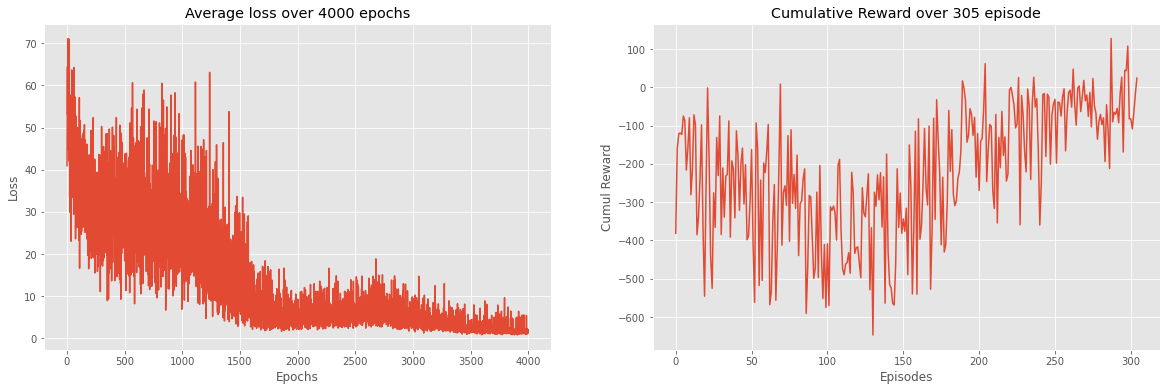

In [11]:
# Set hyperparameters
tau = 0.01
epsilon = 1
epsilon_decay_factor = 0.995
discount_factor = 0.99
batch_size = 128
learning_rate = 0.001
num_epochs = 4001

# Initialize Policy and buffer
policy = Policy(eps=epsilon)
buffer = ERB(size=30000)

# Create environment
env = gym.make("LunarLander-v2")

# Initialize model network and build it dynamically (according to enviroment's observation space)
model_network = DQN(env)
model_network.build(input_shape=(None, env.observation_space.shape[0]))

# Initialize target network and build it dynamically (according to enviroment's observation space)
target_network = DQN(env)
target_network.build(input_shape=(None, env.observation_space.shape[0]))

# Copy weights from model to target network
target_network.set_weights(model_network.get_weights())

# Train the model network and save the final weights
train_DQN(env=env, model_network=model_network, target_network=target_network, policy=policy, buffer=buffer, num_epochs=num_epochs, batch_size=batch_size, learning_rate=0.001, discount_factor=discount_factor, epsilon=epsilon, epsilon_decay_factor=epsilon_decay_factor, tau=tau)
model_network.save_weights("LunarLanderDQNWeights_8000")

### Train for another 4000 Epochs as cumulative reward is still relatively low
(Note: Plotting and saving functions were manually adjusted to display correct epochs etc.)

The last epoch took: 10.5751 seconds



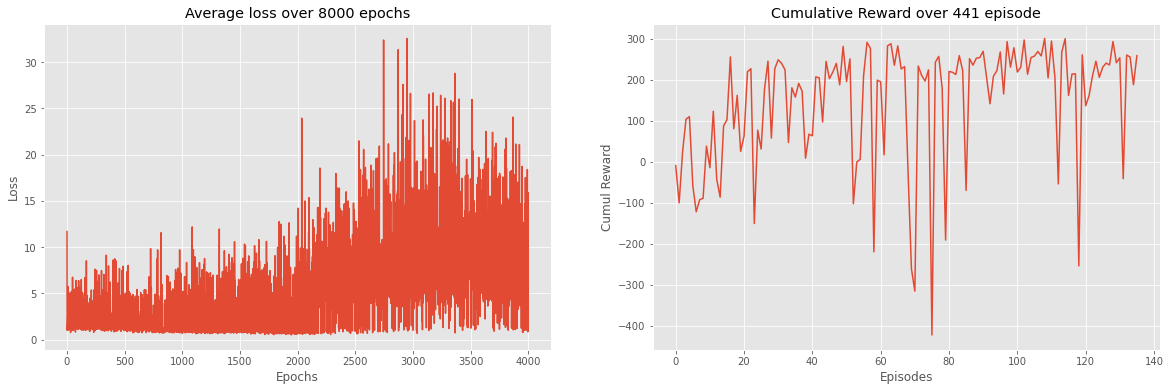

In [20]:
train_DQN(env=env, model_network=model_network, target_network=target_network, policy=policy, buffer=buffer, num_epochs=num_epochs, max_steps=max_steps, batch_size=batch_size, learning_rate=0.001, discount_factor=discount_factor, epsilon=epsilon, epsilon_decay_factor=epsilon_decay_factor, tau=tau)

## Evaluation Videos

### Before Training:

In [15]:
embed_mp4("eval_vid_epoch_0.mp4")

### During Training:

In [15]:
embed_mp4("eval_vid_epoch_3000.mp4")

In [24]:
embed_mp4("eval_vid_epoch_6000.mp4")

### After Training:

In [23]:
embed_mp4("eval_vid_epoch_8000.mp4")